In [1]:
# get required packages

import itertools
import pandas as pd
import numpy as np

#for modeling
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose as sd
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LassoLarsCV

#for visualizations
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from matplotlib.pylab import rcParams
import time

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter("ignore")

In [2]:
# Zillow data for home sales from 1996 to 2018 by state,city
# load the data into data frame
df = pd.read_csv('zillow_data.csv')
df.head()

RegionID  RegionName      City State              Metro CountyName  \
0     84654       60657   Chicago    IL            Chicago       Cook   
1     90668       75070  McKinney    TX  Dallas-Fort Worth     Collin   
2     91982       77494      Katy    TX            Houston     Harris   
3     84616       60614   Chicago    IL            Chicago       Cook   
4     93144       79936   El Paso    TX            El Paso    El Paso   

   SizeRank   1996-04   1996-05   1996-06  ...  2017-07  2017-08  2017-09  \
0         1  334200.0  335400.0  336500.0  ...  1005500  1007500  1007800   
1         2  235700.0  236900.0  236700.0  ...   308000   310000   312500   
2         3  210400.0  212200.0  212200.0  ...   321000   320600   320200   
3         4  498100.0  500900.0  503100.0  ...  1289800  1287700  1287400   
4         5   77300.0   77300.0   77300.0  ...   119100   119400   120000   

   2017-10  2017-11  2017-12  2018-01  2018-02  2018-03  2018-04  
0  1009600  1013300  1018700  1024400  1030700  1033800  1030600  
1   314100   315000   316600   318100   319600   321100   321800  
2   320400   320800   321200   321200   323000   326900   329900  
3  1291500  1296600  1299000  1302700  1306400  1308500  1307000  
4   120300   120300   120300   120300   120500   121000   121500  

[5 rows x 272 columns]

In [3]:
# The real estate market is very hot in california due to job market 
# so will analyze the california data
ca=df[(df['State']=='CA')]

In [4]:
area = pd.read_csv('California_zip.csv')
area.head()

RegionName     District
0       90001  Los Angeles
1       90002  Los Angeles
2       90003  Los Angeles
3       90004  Los Angeles
4       90005  Los Angeles

In [5]:
ca1 = pd.merge(ca, area, how='left', on='RegionName')

In [6]:
ca1.head()

RegionID  RegionName           City State                           Metro  \
0     97564       94109  San Francisco    CA                   San Francisco   
1     96107       90250      Hawthorne    CA  Los Angeles-Long Beach-Anaheim   
2     97771       94565      Pittsburg    CA                   San Francisco   
3     96027       90046    Los Angeles    CA  Los Angeles-Long Beach-Anaheim   
4     97711       94501        Alameda    CA                   San Francisco   

      CountyName  SizeRank   1996-04   1996-05   1996-06  ...  2017-08  \
0  San Francisco        10  766000.0  771100.0  776500.0  ...  3763900   
1    Los Angeles        16  152500.0  152600.0  152600.0  ...   585700   
2   Contra Costa        28  139200.0  138300.0  137500.0  ...   398400   
3    Los Angeles        31  340600.0  341700.0  343000.0  ...  1861100   
4        Alameda        65  222400.0  222300.0  222400.0  ...   975000   

   2017-09  2017-10  2017-11  2017-12  2018-01  2018-02  2018-03  2018-04  \
0  3775000  3799700  3793900  3778700  3770800  3763100  3779800  3813500   
1   590900   594700   598500   601300   602800   606100   612400   616200   
2   401600   405400   408600   410900   413700   417900   424300   430100   
3  1888600  1903900  1907500  1922100  1952400  1974500  1975900  1966900   
4   987800  1000000  1009900  1021000  1032400  1042000  1053000  1059700   

        District  
0  San Francisco  
1      Hawthorne  
2      Pittsburg  
3    Los Angeles  
4        Alameda  

[5 rows x 273 columns]

In [7]:
# Reformat wide to long format & Data processing
def melt_data(df):
    melted = pd.melt(df, id_vars=['RegionName','City','Metro','CountyName'], var_name='Month', value_name = 'MeanValue')
    melted['Month'] = pd.to_datetime(melted['Month'], format = '%Y-%m')
    melted = melted.dropna(subset=['MeanValue'])
    return melted

In [8]:
# Drop variables which we do not need
ca2 = ca1.drop(['RegionID','State','SizeRank','District'], axis ='columns')
ca2.head()

RegionName           City                           Metro     CountyName  \
0       94109  San Francisco                   San Francisco  San Francisco   
1       90250      Hawthorne  Los Angeles-Long Beach-Anaheim    Los Angeles   
2       94565      Pittsburg                   San Francisco   Contra Costa   
3       90046    Los Angeles  Los Angeles-Long Beach-Anaheim    Los Angeles   
4       94501        Alameda                   San Francisco        Alameda   

    1996-04   1996-05   1996-06   1996-07   1996-08   1996-09  ...  2017-07  \
0  766000.0  771100.0  776500.0  781900.0  787300.0  793000.0  ...  3767700   
1  152500.0  152600.0  152600.0  152600.0  152600.0  152600.0  ...   579300   
2  139200.0  138300.0  137500.0  136600.0  135600.0  134700.0  ...   394900   
3  340600.0  341700.0  343000.0  344400.0  346100.0  348000.0  ...  1839800   
4  222400.0  222300.0  222400.0  222600.0  223000.0  223600.0  ...   965100   

   2017-08  2017-09  2017-10  2017-11  2017-12  2018-01  2018-02  2018-03  \
0  3763900  3775000  3799700  3793900  3778700  3770800  3763100  3779800   
1   585700   590900   594700   598500   601300   602800   606100   612400   
2   398400   401600   405400   408600   410900   413700   417900   424300   
3  1861100  1888600  1903900  1907500  1922100  1952400  1974500  1975900   
4   975000   987800  1000000  1009900  1021000  1032400  1042000  1053000   

   2018-04  
0  3813500  
1   616200  
2   430100  
3  1966900  
4  1059700  

[5 rows x 269 columns]

In [9]:
dfm = melt_data(ca2)

In [10]:
dfm.head()

RegionName           City                           Metro     CountyName  \
0       94109  San Francisco                   San Francisco  San Francisco   
1       90250      Hawthorne  Los Angeles-Long Beach-Anaheim    Los Angeles   
2       94565      Pittsburg                   San Francisco   Contra Costa   
3       90046    Los Angeles  Los Angeles-Long Beach-Anaheim    Los Angeles   
4       94501        Alameda                   San Francisco        Alameda   

       Month  MeanValue  
0 1996-04-01   766000.0  
1 1996-04-01   152500.0  
2 1996-04-01   139200.0  
3 1996-04-01   340600.0  
4 1996-04-01   222400.0

In [11]:
dfm.set_index('Month', inplace = True)

In [12]:
# fed_rate is the additional feature 
features = pd.read_csv('fed_rate.csv')
features.head()

Month  Fed_Rate
0  2011-01-01      0.13
1  2011-02-01      0.18
2  2011-03-01      0.15
3  2011-04-01      0.11
4  2011-05-01      0.09

In [13]:
dfm.dtypes

RegionName      int64
City           object
Metro          object
CountyName     object
MeanValue     float64
dtype: object

In [14]:
features['Month'] =  pd.to_datetime(features['Month'])

In [15]:
features.dtypes

Month       datetime64[ns]
Fed_Rate           float64
dtype: object

In [16]:
features.tail()

Month  Fed_Rate
83 2017-12-01      1.16
84 2018-01-01      1.42
85 2018-02-01      1.42
86 2018-03-01      1.42
87 2018-04-01      1.67

In [17]:
dfm.tail()

RegionName               City       Metro      CountyName  \
Month                                                                   
2018-04-01       93517         Bridgeport         NaN            Mono   
2018-04-01       95728            Truckee     Truckee          Nevada   
2018-04-01       95497          Annapolis  Santa Rosa          Sonoma   
2018-04-01       92322          Crestline   Riverside  San Bernardino   
2018-04-01       92341  Green Valley Lake   Riverside  San Bernardino   

            MeanValue  
Month                  
2018-04-01   272500.0  
2018-04-01   496300.0  
2018-04-01   848700.0  
2018-04-01   200100.0  
2018-04-01   183600.0

In [18]:
dfm_fea = pd.merge(dfm, features, how='left', on='Month')

#df_train_new = dfm.merge(features, on=['Month'], how = 'left')
#dfm_fea = pd.concat([dfm, features]) #, how='left', on = 'Month')

In [19]:
dfm_fea.tail()

Month  RegionName               City       Metro      CountyName  \
318739 2018-04-01       93517         Bridgeport         NaN            Mono   
318740 2018-04-01       95728            Truckee     Truckee          Nevada   
318741 2018-04-01       95497          Annapolis  Santa Rosa          Sonoma   
318742 2018-04-01       92322          Crestline   Riverside  San Bernardino   
318743 2018-04-01       92341  Green Valley Lake   Riverside  San Bernardino   

        MeanValue  Fed_Rate  
318739   272500.0      1.67  
318740   496300.0      1.67  
318741   848700.0      1.67  
318742   200100.0      1.67  
318743   183600.0      1.67

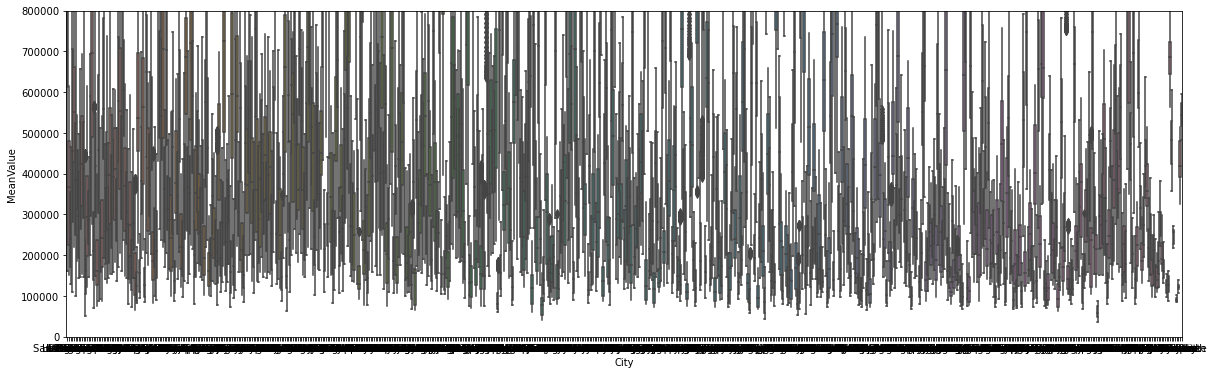

In [20]:
# now see the relation between city and Mean value 
var = 'City'
data = pd.concat([dfm_fea['MeanValue'],dfm_fea[var]],axis=1)
f, ax = plt.subplots(figsize=(20, 6))
fig = sns.boxplot(x=var, y="MeanValue",data=data)
fig.axis(ymin=0,ymax=800000);

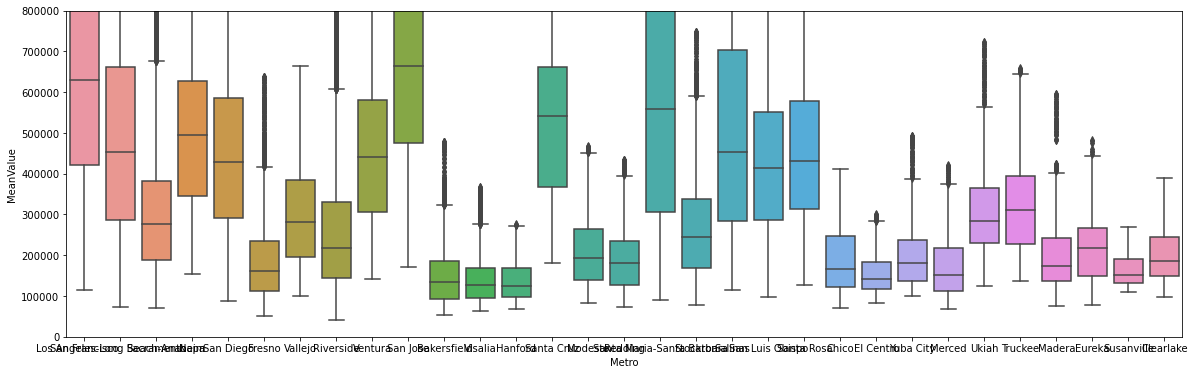

In [21]:
# now see the relation between Metro and Mean value 
var = 'Metro'
data = pd.concat([dfm_fea['MeanValue'],dfm_fea[var]],axis=1)
f, ax = plt.subplots(figsize=(20, 6))
fig = sns.boxplot(x=var, y="MeanValue",data=data)
fig.axis(ymin=0,ymax=800000);

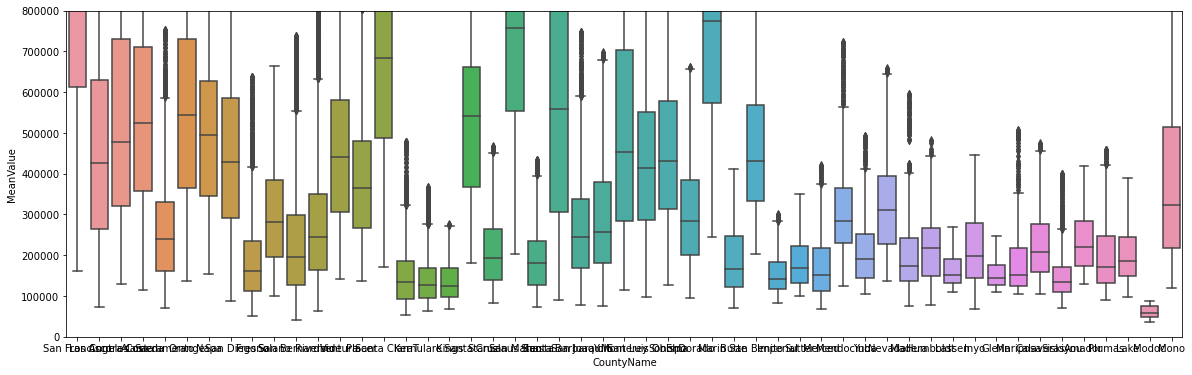

In [22]:
var = 'CountyName'
data = pd.concat([dfm_fea['MeanValue'],dfm_fea[var]],axis=1)
f, ax = plt.subplots(figsize=(20, 6))
fig = sns.boxplot(x=var, y="MeanValue",data=data)
fig.axis(ymin=0,ymax=800000);

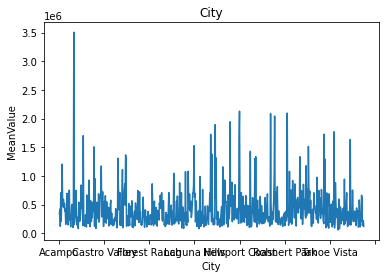

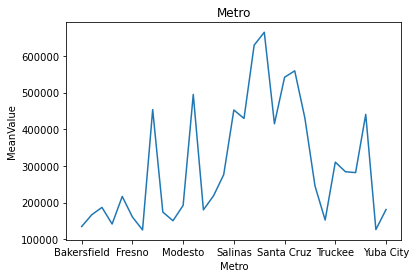

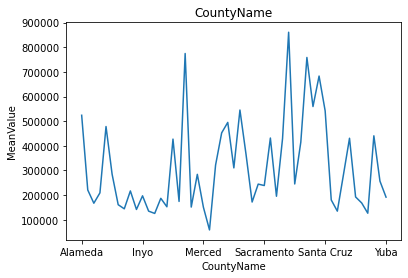

In [23]:
temporal_features = ['City','Metro','CountyName']

for feature in temporal_features:
    data = dfm_fea.copy()
    
    dfm_fea.groupby(feature)['MeanValue'].median().plot()
    plt.xlabel(feature)
    plt.ylabel('MeanValue')
    plt.title(feature)
    plt.show()

In [24]:
# since we have many cities we focus on single city
# will focus just on San Francisco and give suggestions from that city only, since many visitors come to SFO to visit, so that is better
#place to invest, so focus on this city


In [25]:
ca3 = dfm_fea[dfm_fea['City']=='San Francisco']
ca3.head(5)

Month  RegionName           City          Metro     CountyName  \
0   1996-04-01       94109  San Francisco  San Francisco  San Francisco   
6   1996-04-01       94110  San Francisco  San Francisco  San Francisco   
56  1996-04-01       94122  San Francisco  San Francisco  San Francisco   
91  1996-04-01       94112  San Francisco  San Francisco  San Francisco   
132 1996-04-01       94115  San Francisco  San Francisco  San Francisco   

     MeanValue  Fed_Rate  
0     766000.0       NaN  
6     213900.0       NaN  
56    278400.0       NaN  
91    210100.0       NaN  
132   794000.0       NaN

In [26]:
# since we can get discrete values from zip code we can delete Metro,city and CountyName
ca4 = ca3.drop(['Metro','CountyName','City'], axis ='columns')
ca4.tail()

Month  RegionName  MeanValue  Fed_Rate
317971 2018-04-01       94133  3014600.0      1.67
318062 2018-04-01       94134   948200.0      1.67
318096 2018-04-01       94132  1344700.0      1.67
318119 2018-04-01       94124   888200.0      1.67
318294 2018-04-01       94127  1758400.0      1.67

In [27]:
# from dfm also remove all other cities other than Dallas 

In [28]:
dfm1 = ca4

In [29]:
dfm1.tail()

Month  RegionName  MeanValue  Fed_Rate
317971 2018-04-01       94133  3014600.0      1.67
318062 2018-04-01       94134   948200.0      1.67
318096 2018-04-01       94132  1344700.0      1.67
318119 2018-04-01       94124   888200.0      1.67
318294 2018-04-01       94127  1758400.0      1.67

In [30]:
dfm1.set_index('Month', inplace = True)

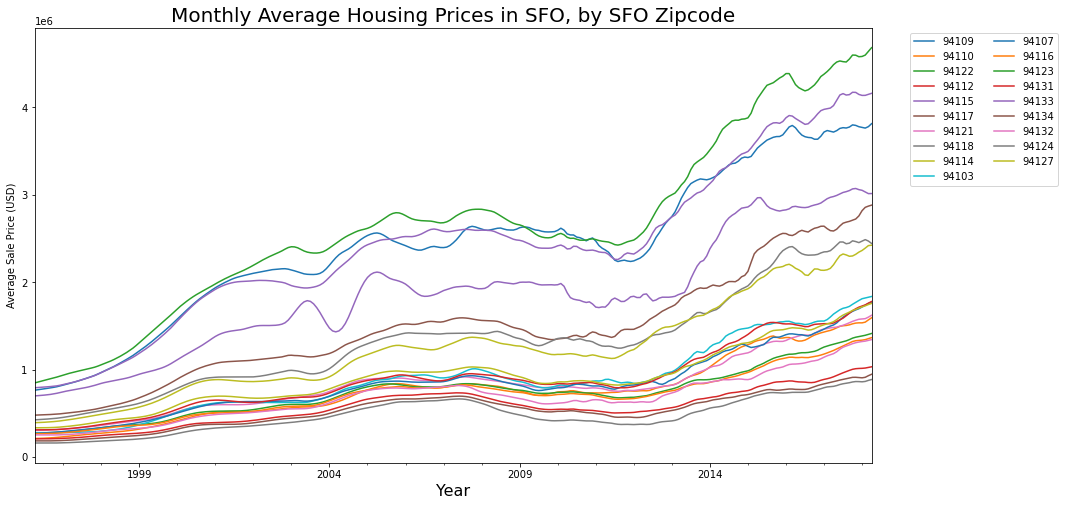

In [31]:
#EDA and Visualization

for zipcode in dfm1.RegionName.unique():
    temp_df = dfm1[dfm1.RegionName == zipcode]
    temp_df['MeanValue'].plot(figsize = (15,8), label=zipcode)

plt.legend(bbox_to_anchor=(1.04,1), loc='upper left', ncol=2)
plt.xlabel("Year", fontsize = 16)
plt.ylabel("Average Sale Price (USD)")
plt.title('Monthly Average Housing Prices in SFO, by SFO Zipcode', fontsize = 20);

41 zip codes have data from 1996 to 2018, however, There was a dip from 2008 and 2010 because of the financial crisis, housing price became stable around 2011.

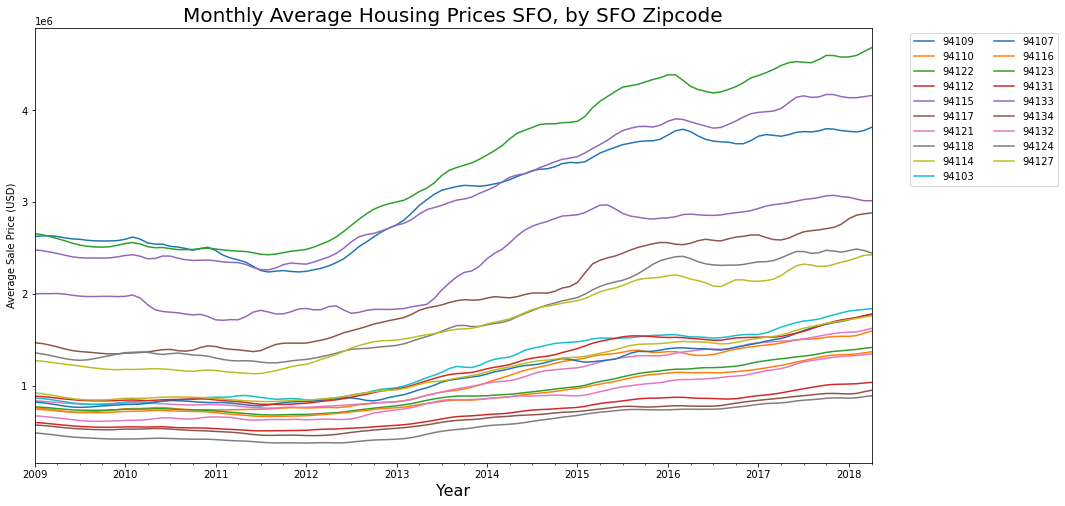

In [32]:
#A deeper look at 2008 above
for zipcode in dfm1.RegionName.unique():
    temp_df = dfm1[dfm1.RegionName == zipcode]
    temp_df['2009':]['MeanValue'].plot(figsize = (15,8), label=zipcode)

plt.legend(bbox_to_anchor=(1.04,1), loc='upper left', ncol=2)
plt.xlabel("Year", fontsize = 16)
plt.ylabel("Average Sale Price (USD)")
plt.title('Monthly Average Housing Prices SFO, by SFO Zipcode', fontsize = 20);

In [33]:
#To get more accurate prediction on future data, we decided to use data 2011-Present.
df2011 = dfm1['2011':]


In [34]:
# now split data into train and test data set 
train_df = df2011[:int(0.8*(len(df2011)))]
test_df = df2011[int(0.8*(len(df2011))):]

In [35]:
test_df.tail()

RegionName  MeanValue  Fed_Rate
Month                                      
2018-04-01       94133  3014600.0      1.67
2018-04-01       94134   948200.0      1.67
2018-04-01       94132  1344700.0      1.67
2018-04-01       94124   888200.0      1.67
2018-04-01       94127  1758400.0      1.67

In [36]:
train_month_avg = train_df.groupby('Month')['MeanValue'].mean()

In [37]:
train_month_avg.head()

Month
2011-01-01    1.124511e+06
2011-02-01    1.115047e+06
2011-03-01    1.109189e+06
2011-04-01    1.104174e+06
2011-05-01    1.098742e+06
Name: MeanValue, dtype: float64

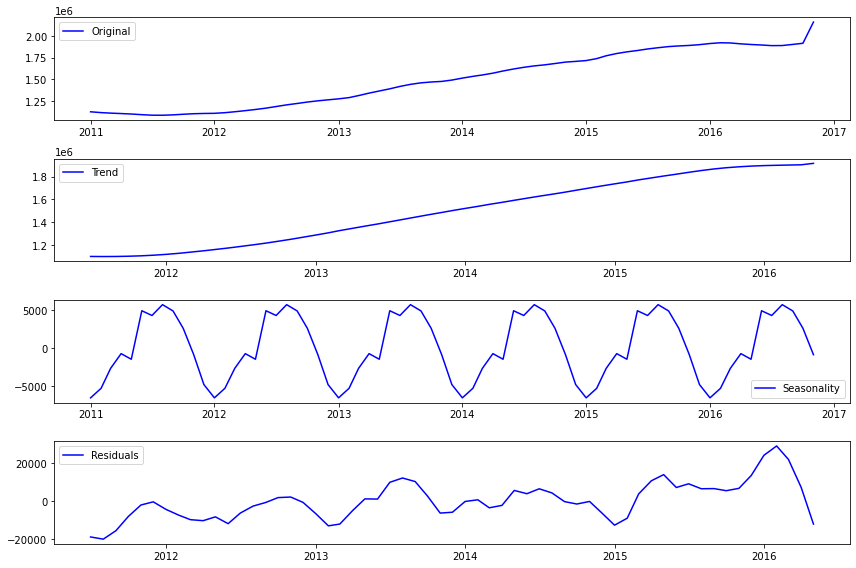

In [38]:
# now check the seasonality in train data set 
decomposition = sm.tsa.seasonal_decompose(train_month_avg, model='additive')

#Gather the trend, seasonality, and residuals
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot gathered statistics
plt.figure(figsize=(12,8))
plt.subplot(411)
plt.plot(train_month_avg, label='Original', color='blue')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend', color='blue')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality', color='blue')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals', color='blue')
plt.legend(loc='best')
plt.tight_layout()

An upward trend is present with yearly sesasonal changes.So we have seasonality in this

<AxesSubplot:xlabel='Month'>

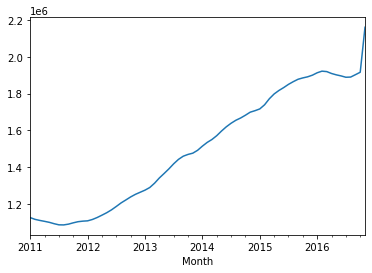

In [39]:
train_month_avg.plot()

In [40]:
train = train_df['MeanValue']
test = test_df['MeanValue']

In [41]:
train.tail()

Month
2016-11-01    1223700.0
2016-11-01     867500.0
2016-11-01    3926000.0
2016-11-01    2626500.0
2016-11-01    1436400.0
Name: MeanValue, dtype: float64

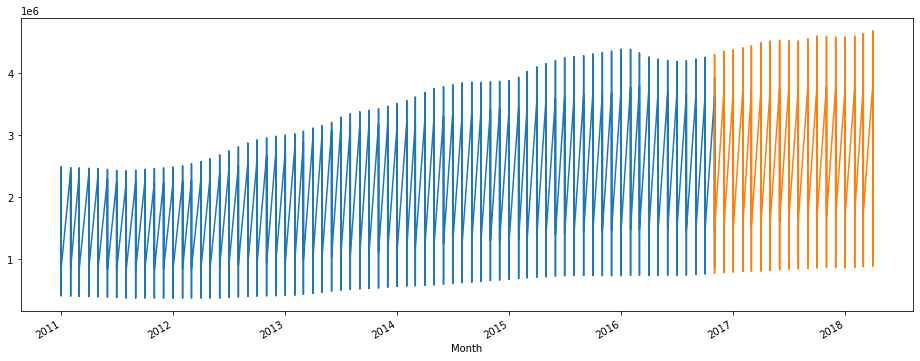

In [42]:
# prediction with out any additional variables 
train.plot(figsize=(16,6))
test.plot(figsize=(16,6))
plt.show()

The monthly average house price of Texas increased year over year. Now check acf and pacf.

In [43]:
def adf_test(series):
    result=adfuller(series)
    print('ADF Statistics: {}'.format(result[0]))
    print('p- value: {}'.format(result[1]))
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

In [44]:
adf_test(train_month_avg)

ADF Statistics: 2.311303219017868
p- value: 0.9989622513679852
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


#Now check Auto correlation

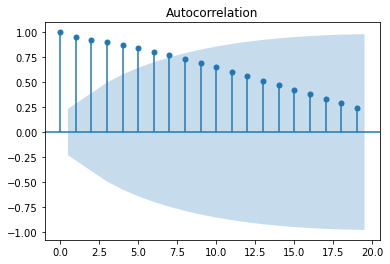

In [45]:
acf = plot_acf(train_month_avg)

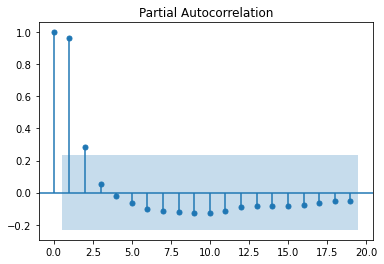

In [46]:
pacf = plot_pacf(train_month_avg)

In [47]:
#plot_acf(train_month_avg); plt.xlim(0,24); plt.show()
#plot_pacf(train_month_avg); plt.xlim(0,24); plt.ylim(-1,1);plt.show()

from above ACF there is no autocorrelation so If take lag = 2 and lag = 3 difference to Autocorrlation to appear. So using lag = 3 for our analysis

<AxesSubplot:xlabel='Month'>

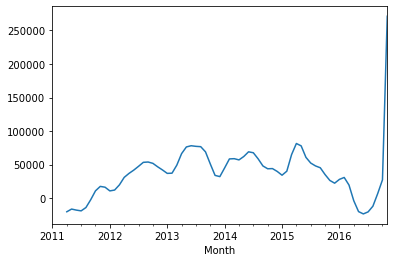

In [48]:
train_month_avg.diff(periods=3).plot()

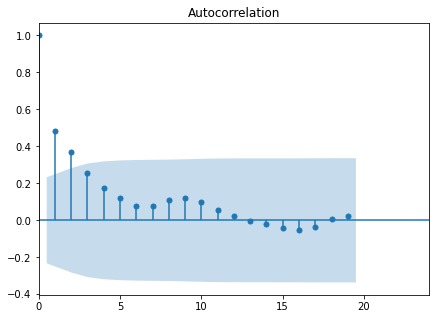

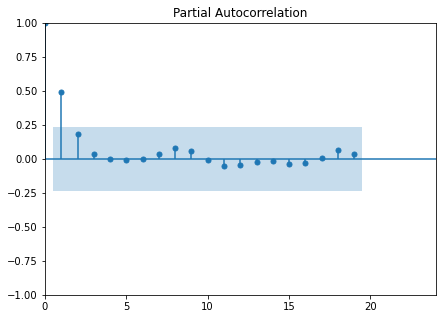

In [49]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from matplotlib.pylab import rcParams

rcParams['figure.figsize']=7,5
plot_acf(train_month_avg.diff(periods=3).bfill()); plt.xlim(0,24); plt.show()
plot_pacf(train_month_avg.diff(periods=3).bfill()); plt.xlim(0,24); plt.ylim(-1,1);plt.show()

 From above ACF and PACF we can tell this has AR1 and MA 2 process

Step 4: Initial SARIMA Models on Sample Zip Codes

In [50]:
dfm1.RegionName.unique()

array([94109, 94110, 94122, 94112, 94115, 94117, 94121, 94118, 94114,
       94103, 94107, 94116, 94123, 94131, 94133, 94134, 94132, 94124,
       94127], dtype=int64)

In [51]:
#Select 5 zipcodes to check best model 
zip_dfs = []
zip_list = np.array([94109, 94110, 94122, 94112, 94115])
for x in zip_list:
    zip_dfs.append(pd.DataFrame(dfm1[dfm1['RegionName']==x][['MeanValue']].copy()))

In [52]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0,2)
# Generate all different combinations of p, d and q triplets
pdq = list(itertools.product(p,d,q))
# Generate all different combinations of seasonal p, d and q triplets
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [53]:
print(pdqs)

[(0, 0, 0, 12), (0, 0, 1, 12), (0, 1, 0, 12), (0, 1, 1, 12), (1, 0, 0, 12), (1, 0, 1, 12), (1, 1, 0, 12), (1, 1, 1, 12)]


In [54]:
#Run SARIMA
ans = []

for df, name in zip(zip_dfs, zip_list):
    for para1 in pdq:
        for para2 in pdqs:
            try:
                mod = sm.tsa.statespace.SARIMAX(df,
                                                order = para1,
                                                seasonal_order = para2,
                                                enforce_stationarity = False,
                                                enforce_invertibility = False)
                output = mod.fit()
                ans.append([name, para1, para2, output.aic])
                print('Result for {}'.format(name) + ' ARIMA {} x {}12 : AIC Calculated = {}'.format(para1, para2, output.aic))
            except:
                continue

Result for 94109 ARIMA (0, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated = 8537.222003188986
Result for 94109 ARIMA (0, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated = 7996.685706171333
Result for 94109 ARIMA (0, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated = 6966.647693921467
Result for 94109 ARIMA (0, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated = 6594.707974171481
Result for 94109 ARIMA (0, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated = 6924.623646586941
Result for 94109 ARIMA (0, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated = 6877.474807998004
Result for 94109 ARIMA (0, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated = 6602.114335598667
Result for 94109 ARIMA (0, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated = 6569.592042126204
Result for 94109 ARIMA (0, 0, 1) x (0, 0, 0, 12)12 : AIC Calculated = 8313.85679446194
Result for 94109 ARIMA (0, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated = 7892.074293823895
Result for 94109 ARIMA (0, 0, 1) x (0, 1, 0, 12)12 : AIC Calculated = 7122.416961629075
Result for 94109 ARIMA (0, 0, 1) 

Result for 94110 ARIMA (0, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated = 4851.434215214829
Result for 94110 ARIMA (1, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated = 5483.577879762723
Result for 94110 ARIMA (1, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated = 5282.2738300346045
Result for 94110 ARIMA (1, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated = 5374.627723861198
Result for 94110 ARIMA (1, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated = 7316.070459355255
Result for 94110 ARIMA (1, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated = 5242.842099984936
Result for 94110 ARIMA (1, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated = 5242.384735667826
Result for 94110 ARIMA (1, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated = 5103.806598987659
Result for 94110 ARIMA (1, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated = 6768.099558981401
Result for 94110 ARIMA (1, 0, 1) x (0, 0, 0, 12)12 : AIC Calculated = 5220.075704143304
Result for 94110 ARIMA (1, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated = 4986.74266317813
Result for 94110 ARIMA (1, 0, 1)

Result for 94122 ARIMA (1, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated = 4416.406056025457
Result for 94122 ARIMA (1, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated = 4423.643122018311
Result for 94122 ARIMA (1, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated = 4382.309139692731
Result for 94112 ARIMA (0, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated = 7780.780247702885
Result for 94112 ARIMA (0, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated = 7276.29679998692
Result for 94112 ARIMA (0, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated = 6331.305158505175
Result for 94112 ARIMA (0, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated = 6041.472721501741
Result for 94112 ARIMA (0, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated = 6282.29628907819
Result for 94112 ARIMA (0, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated = 6219.043580164634
Result for 94112 ARIMA (0, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated = 5916.7907396582605
Result for 94112 ARIMA (0, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated = 7811.454336888086
Result for 94112 ARIMA (0, 0, 1) 

Result for 94115 ARIMA (0, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated = 5310.860680136129
Result for 94115 ARIMA (0, 1, 1) x (1, 0, 0, 12)12 : AIC Calculated = 5536.271558181558
Result for 94115 ARIMA (0, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated = 5485.49285845465
Result for 94115 ARIMA (0, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated = 5332.174909102521
Result for 94115 ARIMA (0, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated = 5312.857849595802
Result for 94115 ARIMA (1, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated = 5968.517488825069
Result for 94115 ARIMA (1, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated = 5704.5445891581185
Result for 94115 ARIMA (1, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated = 5823.389015657132
Result for 94115 ARIMA (1, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated = 5583.171773751643
Result for 94115 ARIMA (1, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated = 5703.560269821668
Result for 94115 ARIMA (1, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated = 5704.99108399229
Result for 94115 ARIMA (1, 0, 0) 

In [55]:
result = pd.DataFrame(ans, columns = ['name','pdq','pdqs','AIC'])

The Akaike Information Critera (AIC) is a widely used measure of a statistical model. It basically quantifies 1) the goodness of fit, and 2) the simplicity/parsimony, of the model into a single statistic.

When comparing two models, the one with the lower AIC is generally “better”.

In [56]:
#Return the best set of parameters based on AIC
best_parameters = result.loc[result.groupby("name")["AIC"].idxmin()]

In [57]:
# best parameters for first 10 zip codes 
best_parameters

name        pdq           pdqs          AIC
63   94109  (1, 1, 1)  (1, 1, 1, 12)  5213.913980
127  94110  (1, 1, 1)  (1, 1, 1, 12)  4615.661859
255  94112  (1, 1, 1)  (1, 1, 1, 12)  4300.348734
319  94115  (1, 1, 1)  (1, 1, 1, 12)  5142.710302
191  94122  (1, 1, 1)  (1, 1, 1, 12)  4382.309140

In [58]:
# from above results the best model is (1,1,1) and (1,1,1,12) for seasonal
# so use that to model train and fit test 
model_SARIMA = SARIMAX(train,order=(1,1,1),seasonal_order=(1,1,1,12))
model_SARIMA_fit = model_SARIMA.fit()
model_SARIMA_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                          MeanValue   No. Observations:                 1337
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood              -20150.077
Date:                            Wed, 20 Apr 2022   AIC                          40310.153
Time:                                    10:40:58   BIC                          40336.095
Sample:                                         0   HQIC                         40319.878
                                           - 1337                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1020      0.075     -1.363      0.173      -0.249       0.045
ma.L1         -0.9955      0.022    -45.242      0.000      -1.039      -0.952
ar.S.L12       0.2609      0.067      3.904      0.000       0.130       0.392
ma.S.L12      -0.9792      0.053    -18.359      0.000      -1.084      -0.875
sigma2      1.629e+12   1.51e-14   1.08e+26      0.000    1.63e+12    1.63e+12
===================================================================================
Ljung-Box (L1) (Q):                   0.57   Jarque-Bera (JB):               132.54
Prob(Q):                              0.45   Prob(JB):                         0.00
Heteroskedasticity (H):               2.22   Skew:                             0.77
Prob(H) (two-sided):                  0.00   Kurtosis:                         2.97
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.88e+41. Standard errors may be unstable.
"""

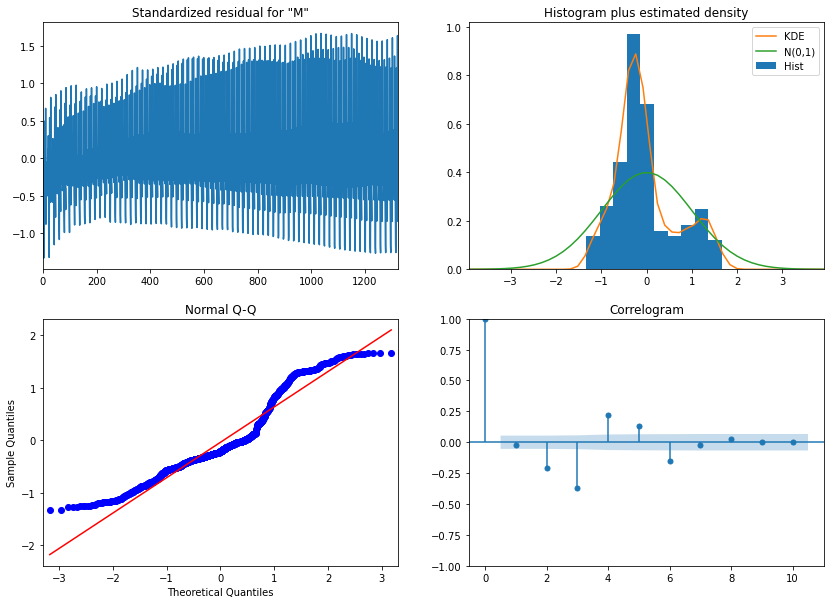

In [59]:
model_SARIMA_fit.plot_diagnostics(figsize=(14,10));

Plug the optimal parameter values into a new SARIMAX model to have a deeper look

In [60]:
# plug the optimal parameter values into a new SARIMAX model.

for name, pdq, pdqs, df in zip(best_parameters['name'], best_parameters['pdq'], best_parameters['pdqs'], zip_dfs):
    
    ARIMA_MODEL = sm.tsa.SARIMAX(df, 
                           order = pdq,
                           seasonal_order = pdqs,
                           enforce_stationarity = False,
                           enforce_invertibility = False)
    
    output = ARIMA_MODEL.fit()
    print('SARIMA Model Result for {}'.format(name))
    print(output.summary().tables[1])
                           
                           
# Fit the model and print results

SARIMA Model Result for 94109
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7772      0.048     16.310      0.000       0.684       0.871
ma.L1          0.3972      0.028     14.422      0.000       0.343       0.451
ar.S.L12      -0.4302      0.069     -6.198      0.000      -0.566      -0.294
ma.S.L12      -0.0352      0.054     -0.653      0.514      -0.141       0.070
sigma2      2.003e+08   1.08e-10   1.85e+18      0.000       2e+08       2e+08
SARIMA Model Result for 94110
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7868      0.027     29.066      0.000       0.734       0.840
ma.L1          0.7128      0.029     24.811      0.000       0.656       0.769
ar.S.L12       0.3150      0.080      3.947      0.000       0.159     

Make dynamic forecast using data up to 2017-01-01 and compare with real values post 2017-01-01

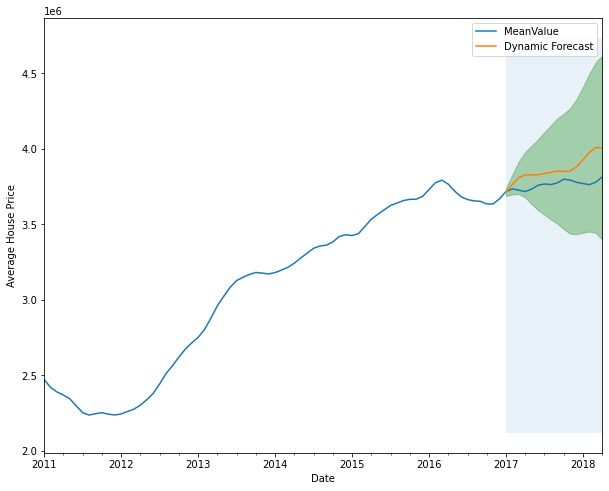

The Mean Squared Error of our forecasts is 119524.68


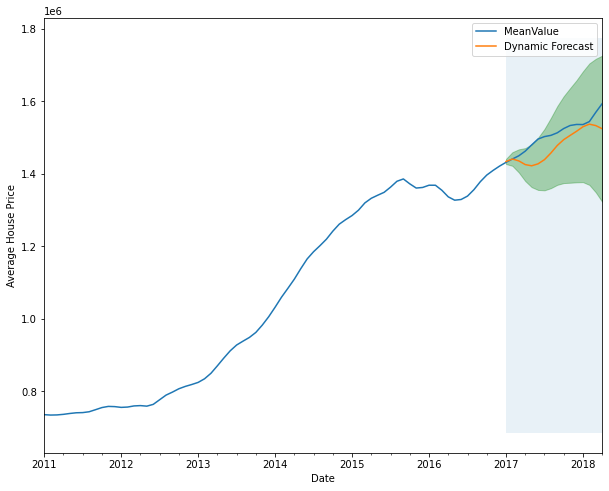

The Mean Squared Error of our forecasts is 39920.73


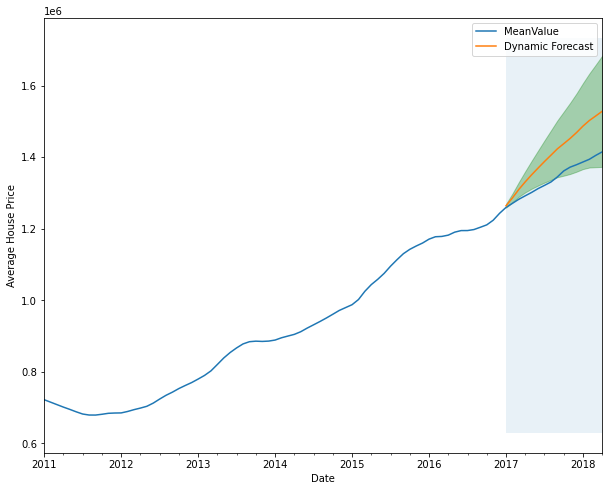

The Mean Squared Error of our forecasts is 75657.66


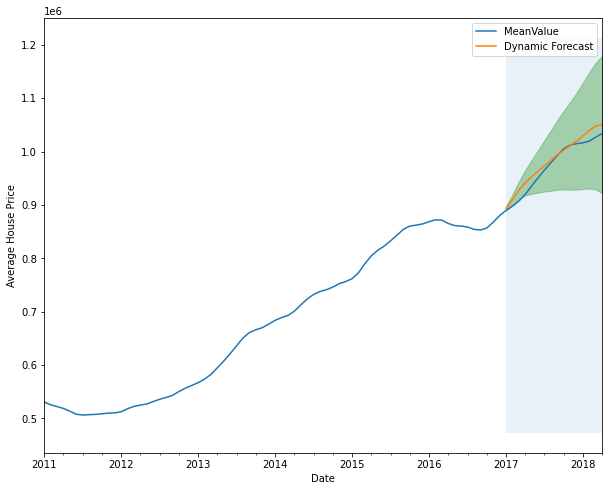

The Mean Squared Error of our forecasts is 13519.66


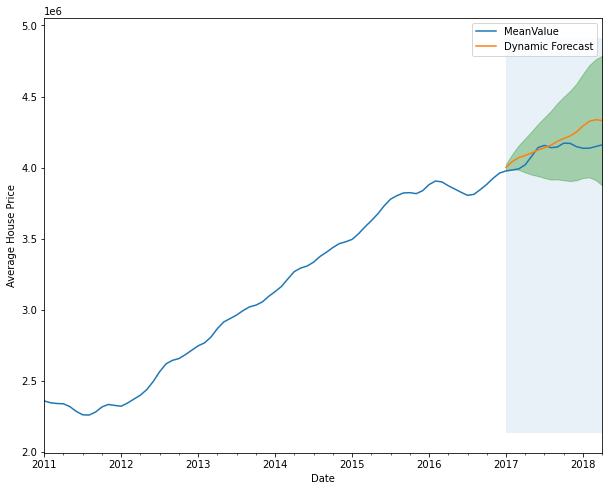

The Mean Squared Error of our forecasts is 99249.46


In [61]:
#Make Prediction post 2017 and compare with real values
summary_table = pd.DataFrame()
Zipcode = []
MSE_Value = []
models = []
for name, pdq, pdqs, df in zip(best_parameters['name'], best_parameters['pdq'], best_parameters['pdqs'], zip_dfs):

    ARIMA_MODEL = sm.tsa.SARIMAX(df,
                                 order = pdq,
                                 seasonal_order = pdqs,
                                 enforce_stationarity = False,
                                 enforce_invertibility = False)
                                
    output = ARIMA_MODEL.fit()
    models.append(output)
    
    #get dynamic predictions starting 2017-06-01
    pred_dynamic = output.get_prediction(start=pd.to_datetime('2017-01-01'), dynamic = True, full_results = True)
    pred_dynamic_conf = pred_dynamic.conf_int()
    zip_forecasted = pred_dynamic.predicted_mean
    zip_truth = df['2017-01-01':]['MeanValue']
    
    #Plot the dynamic forecast with confidence intervals as above
    ax = df['2011':].plot(label='observed', figsize=(10, 8))
    pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

    ax.fill_between(pred_dynamic_conf.index,
                    pred_dynamic_conf.iloc[:, 0],
                    pred_dynamic_conf.iloc[:, 1], color='g', alpha=.3)

    ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2017-01-01'), zip_forecasted.index[-1], alpha=.1, zorder=-1)

    ax.set_xlabel('Date')
    ax.set_ylabel('Average House Price')

    plt.legend()
    plt.show()
    
     #print(type(zip_forecasted))
    #print(zip_truth)
    sqrt_mse = np.sqrt(((zip_forecasted - zip_truth)**2).mean())
    print('The Mean Squared Error of our forecasts is {}'.format(round(sqrt_mse, 2))) 
    
    Zipcode.append(name)
    MSE_Value.append(sqrt_mse)
    
summary_table['Zipcode'] = Zipcode
summary_table['Sqrt_MSE'] = MSE_Value
      

In [62]:
summary_table

Zipcode       Sqrt_MSE
0    94109  119524.679714
1    94110   39920.725084
2    94112   75657.658320
3    94115   13519.660112
4    94122   99249.457882

In [63]:
# now fit the moel with additional variables
model_SARIMA_1 = SARIMAX(train,order=(1,1,1),seasonal_order=(1,1,1,12),exog = train_df[['Fed_Rate']])
model_SARIMA_fit_1 = model_SARIMA_1.fit()
model_SARIMA_fit_1.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                          MeanValue   No. Observations:                 1337
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood              -20149.982
Date:                            Wed, 20 Apr 2022   AIC                          40311.963
Time:                                    10:41:09   BIC                          40343.093
Sample:                                         0   HQIC                         40323.633
                                           - 1337                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Fed_Rate    5.025e+05   7.17e-10   7.01e+14      0.000    5.02e+05    5.02e+05
ar.L1         -0.1023      0.077     -1.329      0.184      -0.253       0.049
ma.L1         -0.9935      0.014    -69.278      0.000      -1.022      -0.965
ar.S.L12       0.2624      0.066      3.972      0.000       0.133       0.392
ma.S.L12      -0.9788      0.053    -18.594      0.000      -1.082      -0.876
sigma2      1.629e+12   1.42e-14   1.14e+26      0.000    1.63e+12    1.63e+12
===================================================================================
Ljung-Box (L1) (Q):                   0.61   Jarque-Bera (JB):               127.98
Prob(Q):                              0.44   Prob(JB):                         0.00
Heteroskedasticity (H):               2.24   Skew:                             0.76
Prob(H) (two-sided):                  0.00   Kurtosis:                         2.95
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 8.36e+41. Standard errors may be unstable.
"""

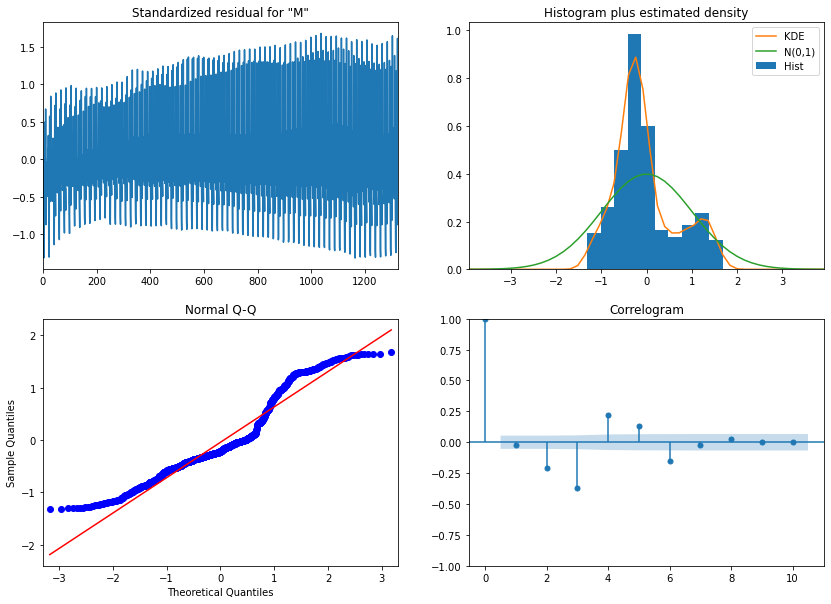

In [64]:
model_SARIMA_fit_1.plot_diagnostics(figsize=(14,10));

# FB Prophet

In [307]:
train = train.to_frame()
train.reset_index(drop=False,inplace=True)
train.rename(columns={'Month':'ds', 'MeanValue':'y'}, inplace = True)

In [310]:
!pip install fbprophet

  ERROR: Command errored out with exit status 1:
   command: 'C:\Users\shiri\anaconda3\python.exe' -u -c 'import io, os, sys, setuptools, tokenize; sys.argv[0] = '"'"'C:\\Users\\shiri\\AppData\\Local\\Temp\\pip-install-f2bvujhn\\fbprophet_d1d337e6a1fb43b2a5c3d5ab8200c60e\\setup.py'"'"'; __file__='"'"'C:\\Users\\shiri\\AppData\\Local\\Temp\\pip-install-f2bvujhn\\fbprophet_d1d337e6a1fb43b2a5c3d5ab8200c60e\\setup.py'"'"';f = getattr(tokenize, '"'"'open'"'"', open)(__file__) if os.path.exists(__file__) else io.StringIO('"'"'from setuptools import setup; setup()'"'"');code = f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' bdist_wheel -d 'C:\Users\shiri\AppData\Local\Temp\pip-wheel-vwn6qgms'
       cwd: C:\Users\shiri\AppData\Local\Temp\pip-install-f2bvujhn\fbprophet_d1d337e6a1fb43b2a5c3d5ab8200c60e\
  Complete output (44 lines):
  running bdist_wheel
  running build
  running build_py
  creating build
  creating build\lib
  creating bu

  Running setup.py clean for fbprophet
  Created wheel for pymeeus: filename=PyMeeus-0.5.11-py3-none-any.whl size=730984 sha256=8099065925806958a8b6e487f339e38907e735037d0fcb5a1a26703d51cf4b5f
  Stored in directory: c:\users\shiri\appdata\local\pip\cache\wheels\33\3d\82\4579e9cca41ff991140b2e050bc6df3a38292f26e4fa06b15d
  Running setup.py clean for pystan
Successfully built pymeeus
Failed to build fbprophet pystan
    Running setup.py install for pystan: started
    Running setup.py install for pystan: finished with status 'error'


    File "C:\Users\shiri\anaconda3\lib\distutils\cmd.py", line 313, in run_command
      self.distribution.run_command(command)
    File "C:\Users\shiri\anaconda3\lib\distutils\dist.py", line 985, in run_command
      cmd_obj.run()
    File "C:\Users\shiri\AppData\Local\Temp\pip-install-f2bvujhn\fbprophet_d1d337e6a1fb43b2a5c3d5ab8200c60e\setup.py", line 48, in run
      build_models(target_dir)
    File "C:\Users\shiri\AppData\Local\Temp\pip-install-f2bvujhn\fbprophet_d1d337e6a1fb43b2a5c3d5ab8200c60e\setup.py", line 36, in build_models
      from fbprophet.models import StanBackendEnum
    File "C:\Users\shiri\AppData\Local\Temp\pip-install-f2bvujhn\fbprophet_d1d337e6a1fb43b2a5c3d5ab8200c60e\fbprophet\__init__.py", line 8, in <module>
      from fbprophet.forecaster import Prophet
    File "C:\Users\shiri\AppData\Local\Temp\pip-install-f2bvujhn\fbprophet_d1d337e6a1fb43b2a5c3d5ab8200c60e\fbprophet\forecaster.py", line 17, in <module>
      from fbprophet.make_holidays import get_holiday

In [311]:
from fbprophet import Prophet

  copying pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\circular_buffer.hpp -> build\lib.win-amd64-3.9\pystan\stan\lib\stan_math\lib\boost_1.69.0\boost
  copying pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\circular_buffer_fwd.hpp -> build\lib.win-amd64-3.9\pystan\stan\lib\stan_math\lib\boost_1.69.0\boost
  copying pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\compressed_pair.hpp -> build\lib.win-amd64-3.9\pystan\stan\lib\stan_math\lib\boost_1.69.0\boost
  copying pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\compute.hpp -> build\lib.win-amd64-3.9\pystan\stan\lib\stan_math\lib\boost_1.69.0\boost
  copying pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\concept_archetype.hpp -> build\lib.win-amd64-3.9\pystan\stan\lib\stan_math\lib\boost_1.69.0\boost
  copying pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\concept_check.hpp -> build\lib.win-amd64-3.9\pystan\stan\lib\stan_math\lib\boost_1.69.0\boost
  copying pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\config.hpp -> b

ModuleNotFoundError: No module named 'fbprophet'

  copying pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\asio\local\connect_pair.hpp -> build\lib.win-amd64-3.9\pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\asio\local
  copying pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\asio\local\datagram_protocol.hpp -> build\lib.win-amd64-3.9\pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\asio\local
  copying pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\asio\local\stream_protocol.hpp -> build\lib.win-amd64-3.9\pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\asio\local
  creating build\lib.win-amd64-3.9\pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\asio\local\detail
  copying pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\asio\local\detail\endpoint.hpp -> build\lib.win-amd64-3.9\pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\asio\local\detail
  creating build\lib.win-amd64-3.9\pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\asio\local\detail\impl
  copying pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\asio\local\detail\

  copying pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\beast\core\detail\clamp.hpp -> build\lib.win-amd64-3.9\pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\beast\core\detail
  copying pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\beast\core\detail\config.hpp -> build\lib.win-amd64-3.9\pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\beast\core\detail
  copying pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\beast\core\detail\cpu_info.hpp -> build\lib.win-amd64-3.9\pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\beast\core\detail
  copying pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\beast\core\detail\integer_sequence.hpp -> build\lib.win-amd64-3.9\pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\beast\core\detail
  copying pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\beast\core\detail\ostream.hpp -> build\lib.win-amd64-3.9\pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\beast\core\detail
  copying pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\beast\core\detail\s

In [313]:
m = Prophet(seasonality_mode = 'additive')
m.fit(train) # df is a pandas.DataFrame with 'y' and 'ds' columns

NameError: name 'Prophet' is not defined

In [ ]:
future = m.make_future_dataframe(periods=7, freq='MS')
forecast = m.predict(future)
forecast.tail()

In [ ]:
forecast_pred = forecast.tail(7)[['ds','yhat']]
forecast_pred.set_index('ds', inplace=True)
forecast_pred = forecast_pred['yhat']
m.plot(forecast)

  copying pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\compute\algorithm\includes.hpp -> build\lib.win-amd64-3.9\pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\compute\algorithm
  copying pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\compute\algorithm\inclusive_scan.hpp -> build\lib.win-amd64-3.9\pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\compute\algorithm
  copying pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\compute\algorithm\inner_product.hpp -> build\lib.win-amd64-3.9\pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\compute\algorithm
  copying pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\compute\algorithm\inplace_merge.hpp -> build\lib.win-amd64-3.9\pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\compute\algorithm
  copying pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\compute\algorithm\iota.hpp -> build\lib.win-amd64-3.9\pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\compute\algorithm
  copying pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\compute\a

  copying pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\fusion\container\deque\detail\at_impl.hpp -> build\lib.win-amd64-3.9\pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\fusion\container\deque\detail
  copying pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\fusion\container\deque\detail\begin_impl.hpp -> build\lib.win-amd64-3.9\pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\fusion\container\deque\detail
  copying pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\fusion\container\deque\detail\build_deque.hpp -> build\lib.win-amd64-3.9\pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\fusion\container\deque\detail
  copying pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\fusion\container\deque\detail\convert_impl.hpp -> build\lib.win-amd64-3.9\pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\fusion\container\deque\detail
  copying pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\fusion\container\deque\detail\deque_keyed_values.hpp -> build\lib.win-amd64-3.9\pystan\stan\lib\stan_

  copying pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\fusion\container\list\detail\end_impl.hpp -> build\lib.win-amd64-3.9\pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\fusion\container\list\detail
  copying pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\fusion\container\list\detail\equal_to_impl.hpp -> build\lib.win-amd64-3.9\pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\fusion\container\list\detail
  copying pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\fusion\container\list\detail\list_to_cons.hpp -> build\lib.win-amd64-3.9\pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\fusion\container\list\detail
  copying pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\fusion\container\list\detail\next_impl.hpp -> build\lib.win-amd64-3.9\pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\fusion\container\list\detail
  copying pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\fusion\container\list\detail\reverse_cons.hpp -> build\lib.win-amd64-3.9\pystan\stan\lib\stan_math\lib\boos

  copying pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\geometry\srs\projections\proj\eck5.hpp -> build\lib.win-amd64-3.9\pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\geometry\srs\projections\proj
  copying pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\geometry\srs\projections\proj\eqc.hpp -> build\lib.win-amd64-3.9\pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\geometry\srs\projections\proj
  copying pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\geometry\srs\projections\proj\eqdc.hpp -> build\lib.win-amd64-3.9\pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\geometry\srs\projections\proj
  copying pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\geometry\srs\projections\proj\etmerc.hpp -> build\lib.win-amd64-3.9\pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\geometry\srs\projections\proj
  copying pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\geometry\srs\projections\proj\fahey.hpp -> build\lib.win-amd64-3.9\pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\geometry

  creating build\lib.win-amd64-3.9\pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\gil\extension\io\targa
  copying pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\gil\extension\io\targa\old.hpp -> build\lib.win-amd64-3.9\pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\gil\extension\io\targa
  copying pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\gil\extension\io\targa\read.hpp -> build\lib.win-amd64-3.9\pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\gil\extension\io\targa
  copying pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\gil\extension\io\targa\tags.hpp -> build\lib.win-amd64-3.9\pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\gil\extension\io\targa
  copying pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\gil\extension\io\targa\write.hpp -> build\lib.win-amd64-3.9\pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\gil\extension\io\targa
  creating build\lib.win-amd64-3.9\pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\gil\extension\io\targa\detail
  copying pystan\st

  copying pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\hana\experimental\type_name.hpp -> build\lib.win-amd64-3.9\pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\hana\experimental
  copying pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\hana\experimental\view.hpp -> build\lib.win-amd64-3.9\pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\hana\experimental
  creating build\lib.win-amd64-3.9\pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\hana\ext
  copying pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\hana\ext\boost.hpp -> build\lib.win-amd64-3.9\pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\hana\ext
  copying pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\hana\ext\std.hpp -> build\lib.win-amd64-3.9\pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\hana\ext
  creating build\lib.win-amd64-3.9\pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\hana\ext\boost
  copying pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\hana\ext\boost\fusion.hpp -> build\lib.win-amd64-3.9\pystan\

  copying pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\math\quadrature\exp_sinh.hpp -> build\lib.win-amd64-3.9\pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\math\quadrature
  copying pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\math\quadrature\gauss.hpp -> build\lib.win-amd64-3.9\pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\math\quadrature
  copying pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\math\quadrature\gauss_kronrod.hpp -> build\lib.win-amd64-3.9\pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\math\quadrature
  copying pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\math\quadrature\naive_monte_carlo.hpp -> build\lib.win-amd64-3.9\pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\math\quadrature
  copying pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\math\quadrature\sinh_sinh.hpp -> build\lib.win-amd64-3.9\pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\math\quadrature
  copying pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\math\quadrature\tanh_sinh.hpp

  copying pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\mpl\aux_\config\forwarding.hpp -> build\lib.win-amd64-3.9\pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\mpl\aux_\config
  copying pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\mpl\aux_\config\gcc.hpp -> build\lib.win-amd64-3.9\pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\mpl\aux_\config
  copying pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\mpl\aux_\config\gpu.hpp -> build\lib.win-amd64-3.9\pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\mpl\aux_\config
  copying pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\mpl\aux_\config\has_apply.hpp -> build\lib.win-amd64-3.9\pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\mpl\aux_\config
  copying pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\mpl\aux_\config\has_xxx.hpp -> build\lib.win-amd64-3.9\pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\mpl\aux_\config
  copying pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\mpl\aux_\config\integral.hpp -> build\lib.win-amd

  copying pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\multi_index\detail\raw_ptr.hpp -> build\lib.win-amd64-3.9\pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\multi_index\detail
  copying pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\multi_index\detail\restore_wstrict_aliasing.hpp -> build\lib.win-amd64-3.9\pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\multi_index\detail
  copying pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\multi_index\detail\rnd_index_loader.hpp -> build\lib.win-amd64-3.9\pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\multi_index\detail
  copying pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\multi_index\detail\rnd_index_node.hpp -> build\lib.win-amd64-3.9\pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\multi_index\detail
  copying pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\multi_index\detail\rnd_index_ops.hpp -> build\lib.win-amd64-3.9\pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\multi_index\detail
  copying pystan\stan\lib\stan_math\

  creating build\lib.win-amd64-3.9\pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\phoenix\core\detail
  copying pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\phoenix\core\detail\argument.hpp -> build\lib.win-amd64-3.9\pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\phoenix\core\detail
  copying pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\phoenix\core\detail\expression.hpp -> build\lib.win-amd64-3.9\pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\phoenix\core\detail
  copying pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\phoenix\core\detail\function_eval.hpp -> build\lib.win-amd64-3.9\pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\phoenix\core\detail
  copying pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\phoenix\core\detail\index_sequence.hpp -> build\lib.win-amd64-3.9\pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\phoenix\core\detail
  copying pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\phoenix\core\detail\phx2_result.hpp -> build\lib.win-amd64-3.9\pystan\st

  copying pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\preprocessor\list\to_tuple.hpp -> build\lib.win-amd64-3.9\pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\preprocessor\list
  copying pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\preprocessor\list\transform.hpp -> build\lib.win-amd64-3.9\pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\preprocessor\list
  creating build\lib.win-amd64-3.9\pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\preprocessor\list\detail
  copying pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\preprocessor\list\detail\fold_left.hpp -> build\lib.win-amd64-3.9\pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\preprocessor\list\detail
  copying pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\preprocessor\list\detail\fold_right.hpp -> build\lib.win-amd64-3.9\pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\preprocessor\list\detail
  creating build\lib.win-amd64-3.9\pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\preprocessor\list\detail\dmc
  copying 

  copying pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\smart_ptr\detail\local_sp_deleter.hpp -> build\lib.win-amd64-3.9\pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\smart_ptr\detail
  copying pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\smart_ptr\detail\lwm_nop.hpp -> build\lib.win-amd64-3.9\pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\smart_ptr\detail
  copying pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\smart_ptr\detail\lwm_pthreads.hpp -> build\lib.win-amd64-3.9\pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\smart_ptr\detail
  copying pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\smart_ptr\detail\lwm_win32_cs.hpp -> build\lib.win-amd64-3.9\pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\smart_ptr\detail
  copying pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\smart_ptr\detail\operator_bool.hpp -> build\lib.win-amd64-3.9\pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\smart_ptr\detail
  copying pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\smart_ptr\d

  copying pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\spirit\home\karma\generator.hpp -> build\lib.win-amd64-3.9\pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\spirit\home\karma
  copying pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\spirit\home\karma\meta_compiler.hpp -> build\lib.win-amd64-3.9\pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\spirit\home\karma
  copying pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\spirit\home\karma\nonterminal.hpp -> build\lib.win-amd64-3.9\pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\spirit\home\karma
  copying pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\spirit\home\karma\numeric.hpp -> build\lib.win-amd64-3.9\pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\spirit\home\karma
  copying pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\spirit\home\karma\operator.hpp -> build\lib.win-amd64-3.9\pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\spirit\home\karma
  copying pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\spirit\home\k

  creating build\lib.win-amd64-3.9\pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\test\impl
  copying pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\test\impl\compiler_log_formatter.ipp -> build\lib.win-amd64-3.9\pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\test\impl
  copying pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\test\impl\cpp_main.ipp -> build\lib.win-amd64-3.9\pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\test\impl
  copying pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\test\impl\debug.ipp -> build\lib.win-amd64-3.9\pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\test\impl
  copying pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\test\impl\decorator.ipp -> build\lib.win-amd64-3.9\pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\test\impl
  copying pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\test\impl\execution_monitor.ipp -> build\lib.win-amd64-3.9\pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\test\impl
  copying pystan\stan\lib\stan_math\lib\boost

  copying pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\type_erasure\param.hpp -> build\lib.win-amd64-3.9\pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\type_erasure
  copying pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\type_erasure\placeholder.hpp -> build\lib.win-amd64-3.9\pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\type_erasure
  copying pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\type_erasure\placeholder_of.hpp -> build\lib.win-amd64-3.9\pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\type_erasure
  copying pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\type_erasure\rebind_any.hpp -> build\lib.win-amd64-3.9\pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\type_erasure
  copying pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\type_erasure\register_binding.hpp -> build\lib.win-amd64-3.9\pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\type_erasure
  copying pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\type_erasure\relaxed.hpp -> build\lib.win-amd64-3.9\pys

  copying pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\xpressive\detail\core\matchers.hpp -> build\lib.win-amd64-3.9\pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\xpressive\detail\core
  copying pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\xpressive\detail\core\optimize.hpp -> build\lib.win-amd64-3.9\pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\xpressive\detail\core
  copying pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\xpressive\detail\core\peeker.hpp -> build\lib.win-amd64-3.9\pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\xpressive\detail\core
  copying pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\xpressive\detail\core\quant_style.hpp -> build\lib.win-amd64-3.9\pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\xpressive\detail\core
  copying pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\xpressive\detail\core\regex_domain.hpp -> build\lib.win-amd64-3.9\pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\xpressive\detail\core
  copying pystan\stan\lib\stan_math

  copying pystan\stan\lib\stan_math\stan\math\prim\arr\functor\coupled_ode_system.hpp -> build\lib.win-amd64-3.9\pystan\stan\lib\stan_math\stan\math\prim\arr\functorIOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [312]:
# Predicting the test values using predict function.
train = train_df['MeanValue']
forecast_pred = forecast_pred.to_frame()
plt.figure(figsize=(20,6))
plt.title('Prediction of Monthly Sales using FB Prophet', fontsize=20)
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.plot(forecast_pred, label='Prediction using FB Prophet')
plt.legend(loc='best')
plt.xlabel('Month', fontsize=14)
plt.ylabel('MeanValue', fontsize=14)
plt.show()

NameError: name 'forecast_pred' is not defined

Producing and Visualizing Forecasts

In [65]:
forecast_table = pd.DataFrame()
current = []
forecast_3Yr = []
forecast_5Yr =[]
for zipcode, output, df in zip(Zipcode, models, zip_dfs):
    pred_3 = output.get_forecast(steps = 36)
    pred_conf_3 = pred_3.conf_int()
    forecast_3 = pred_3.predicted_mean.to_numpy()[-1]
    pred_5 = output.get_forecast(steps = 60)
    pred_conf_5 = pred_5.conf_int()
    forecast_5 = pred_5.predicted_mean.to_numpy()[-1]
    current.append(df['2018-04']['MeanValue'][0])
    forecast_3Yr.append(forecast_3)
    forecast_5Yr.append(forecast_5)

forecast_table['Zipcode'] = Zipcode
forecast_table['Current Value'] = current
forecast_table['3 Years Value'] = forecast_3Yr
forecast_table['5 Years Value'] = forecast_5Yr
forecast_table['3Yr-ROI']=(forecast_table['3 Years Value'] - forecast_table['Current Value'])/forecast_table['Current Value']
forecast_table['5Yr-ROI']=(forecast_table['5 Years Value'] - forecast_table['Current Value'])/forecast_table['Current Value']

In [68]:
forecast_table

Zipcode  Current Value  3 Years Value  5 Years Value   3Yr-ROI   5Yr-ROI
0    94109      3813500.0   4.443174e+06   4.840189e+06  0.165117  0.269225
1    94110      1594000.0   2.024559e+06   2.306797e+06  0.270112  0.447175
2    94112      1414800.0   1.813940e+06   2.080704e+06  0.282118  0.470670
3    94115      1033800.0   1.404398e+06   1.658896e+06  0.358481  0.604659
4    94122      4160500.0   4.655875e+06   4.980035e+06  0.119066  0.196980

for the first 5 zip codes the 3 year average return on investment is 16.5% and 5 year 26.9%

Step 5: SARIMA models on all Zipcodes
Iterate through all zipcodes.

In [69]:
zip_dfs = []
zip_list = dfm1.RegionName.unique()
for x in zip_list:
    zip_dfs.append(pd.DataFrame(dfm1[dfm1['RegionName']==x][['MeanValue']].copy()))

In [70]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0,2)
# Generate all different combinations of p, d and q triplets
pdq = list(itertools.product(p,d,q))
# Generate all different combinations of seasonal p, d and q triplets
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [71]:
#Run SARIMA
start=time.time()
ans = []

for df, name in zip(zip_dfs, zip_list):
    for para1 in pdq:
        for para2 in pdqs:
            try:
                mod = sm.tsa.statespace.SARIMAX(df,
                                                order = para1,
                                                seasonal_order = para2,
                                                enforce_stationarity = False,
                                                enforce_invertibility = False)
                output = mod.fit()
                ans.append([name, para1, para2, output.aic])
                print('Result for {}'.format(name) + ' ARIMA {} x {}12 : AIC Calculated = {}'.format(para1, para2, output.aic))
            except:
                continue

Result for 94109 ARIMA (0, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated = 8537.222003188986
Result for 94109 ARIMA (0, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated = 7996.685706171333
Result for 94109 ARIMA (0, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated = 6966.647693921467
Result for 94109 ARIMA (0, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated = 6594.707974171481
Result for 94109 ARIMA (0, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated = 6924.623646586941
Result for 94109 ARIMA (0, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated = 6877.474807998004
Result for 94109 ARIMA (0, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated = 6602.114335598667
Result for 94109 ARIMA (0, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated = 6569.592042126204
Result for 94109 ARIMA (0, 0, 1) x (0, 0, 0, 12)12 : AIC Calculated = 8313.85679446194
Result for 94109 ARIMA (0, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated = 7892.074293823895
Result for 94109 ARIMA (0, 0, 1) x (0, 1, 0, 12)12 : AIC Calculated = 7122.416961629075
Result for 94109 ARIMA (0, 0, 1) 

Result for 94110 ARIMA (0, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated = 4897.63528692777
Result for 94110 ARIMA (0, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated = 4851.434215214829
Result for 94110 ARIMA (1, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated = 5483.577879762723
Result for 94110 ARIMA (1, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated = 5282.2738300346045
Result for 94110 ARIMA (1, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated = 5374.627723861198
Result for 94110 ARIMA (1, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated = 7316.070459355255
Result for 94110 ARIMA (1, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated = 5242.842099984936
Result for 94110 ARIMA (1, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated = 5242.384735667826
Result for 94110 ARIMA (1, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated = 5103.806598987659
Result for 94110 ARIMA (1, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated = 6768.099558981401
Result for 94110 ARIMA (1, 0, 1) x (0, 0, 0, 12)12 : AIC Calculated = 5220.075704143304
Result for 94110 ARIMA (1, 0, 1)

Result for 94122 ARIMA (1, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated = 4416.406056025457
Result for 94122 ARIMA (1, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated = 4423.643122018311
Result for 94122 ARIMA (1, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated = 4382.309139692731
Result for 94112 ARIMA (0, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated = 7780.780247702885
Result for 94112 ARIMA (0, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated = 7276.29679998692
Result for 94112 ARIMA (0, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated = 6331.305158505175
Result for 94112 ARIMA (0, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated = 6041.472721501741
Result for 94112 ARIMA (0, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated = 6282.29628907819
Result for 94112 ARIMA (0, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated = 6219.043580164634
Result for 94112 ARIMA (0, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated = 5916.7907396582605
Result for 94112 ARIMA (0, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated = 7811.454336888086
Result for 94112 ARIMA (0, 0, 1) 

Result for 94115 ARIMA (0, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated = 5310.860680136129
Result for 94115 ARIMA (0, 1, 1) x (1, 0, 0, 12)12 : AIC Calculated = 5536.271558181558
Result for 94115 ARIMA (0, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated = 5485.49285845465
Result for 94115 ARIMA (0, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated = 5332.174909102521
Result for 94115 ARIMA (0, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated = 5312.857849595802
Result for 94115 ARIMA (1, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated = 5968.517488825069
Result for 94115 ARIMA (1, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated = 5704.5445891581185
Result for 94115 ARIMA (1, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated = 5823.389015657132
Result for 94115 ARIMA (1, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated = 5583.171773751643
Result for 94115 ARIMA (1, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated = 5703.560269821668
Result for 94115 ARIMA (1, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated = 5704.99108399229
Result for 94115 ARIMA (1, 0, 0) 

Result for 94117 ARIMA (1, 1, 1) x (0, 0, 1, 12)12 : AIC Calculated = 5207.000187143507
Result for 94117 ARIMA (1, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated = 5462.863449391129
Result for 94117 ARIMA (1, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated = 5112.198047556936
Result for 94117 ARIMA (1, 1, 1) x (1, 0, 0, 12)12 : AIC Calculated = 5228.025706488406
Result for 94117 ARIMA (1, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated = 5205.875248662047
Result for 94117 ARIMA (1, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated = 5145.590280805561
Result for 94117 ARIMA (1, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated = 5106.541409355915
Result for 94121 ARIMA (0, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated = 7981.89585252124
Result for 94121 ARIMA (0, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated = 7468.062812563061
Result for 94121 ARIMA (0, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated = 6478.563633769841
Result for 94121 ARIMA (0, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated = 6181.525067951507
Result for 94121 ARIMA (0, 0, 0) 

Result for 94118 ARIMA (0, 1, 1) x (0, 0, 1, 12)12 : AIC Calculated = 5300.925521466017
Result for 94118 ARIMA (0, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated = 5529.637084041075
Result for 94118 ARIMA (0, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated = 5129.028004422646
Result for 94118 ARIMA (0, 1, 1) x (1, 0, 0, 12)12 : AIC Calculated = 5347.941760714855
Result for 94118 ARIMA (0, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated = 5302.903231225577
Result for 94118 ARIMA (0, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated = 5213.803758072976
Result for 94118 ARIMA (0, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated = 5129.695811044255
Result for 94118 ARIMA (1, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated = 5780.444856497409
Result for 94118 ARIMA (1, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated = 5603.7231823540205
Result for 94118 ARIMA (1, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated = 5669.339377112505
Result for 94118 ARIMA (1, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated = 5413.259749602158
Result for 94118 ARIMA (1, 0, 0

Result for 94114 ARIMA (1, 1, 0) x (1, 1, 1, 12)12 : AIC Calculated = 5042.143787929555
Result for 94114 ARIMA (1, 1, 1) x (0, 0, 0, 12)12 : AIC Calculated = 5321.1976056316835
Result for 94114 ARIMA (1, 1, 1) x (0, 0, 1, 12)12 : AIC Calculated = 4992.106798432027
Result for 94114 ARIMA (1, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated = 5316.703395217283
Result for 94114 ARIMA (1, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated = 4950.433919279924
Result for 94114 ARIMA (1, 1, 1) x (1, 0, 0, 12)12 : AIC Calculated = 5012.492805168807
Result for 94114 ARIMA (1, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated = 4983.672740686081
Result for 94114 ARIMA (1, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated = 5013.236686624924
Result for 94114 ARIMA (1, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated = 4951.1306539170555
Result for 94103 ARIMA (0, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated = 8029.924329049309
Result for 94103 ARIMA (0, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated = 7513.684253750987
Result for 94103 ARIMA (0, 0, 

Result for 94107 ARIMA (0, 1, 0) x (1, 0, 1, 12)12 : AIC Calculated = 5363.976480587817
Result for 94107 ARIMA (0, 1, 0) x (1, 1, 0, 12)12 : AIC Calculated = 5153.900672525346
Result for 94107 ARIMA (0, 1, 0) x (1, 1, 1, 12)12 : AIC Calculated = 5122.867741222143
Result for 94107 ARIMA (0, 1, 1) x (0, 0, 0, 12)12 : AIC Calculated = 5384.515936805345
Result for 94107 ARIMA (0, 1, 1) x (0, 0, 1, 12)12 : AIC Calculated = 5141.774669666853
Result for 94107 ARIMA (0, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated = 5326.822947141772
Result for 94107 ARIMA (0, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated = 4941.235746441266
Result for 94107 ARIMA (0, 1, 1) x (1, 0, 0, 12)12 : AIC Calculated = 5185.2667939770945
Result for 94107 ARIMA (0, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated = 5143.754415162227
Result for 94107 ARIMA (0, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated = 5033.9779549181585
Result for 94107 ARIMA (0, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated = 4936.183514051814
Result for 94107 ARIMA (1, 0, 

Result for 94116 ARIMA (1, 1, 0) x (0, 1, 1, 12)12 : AIC Calculated = 4452.3687118853295
Result for 94116 ARIMA (1, 1, 0) x (1, 0, 0, 12)12 : AIC Calculated = 4488.427682242171
Result for 94116 ARIMA (1, 1, 0) x (1, 0, 1, 12)12 : AIC Calculated = 4490.427671424265
Result for 94116 ARIMA (1, 1, 0) x (1, 1, 0, 12)12 : AIC Calculated = 4396.1722253121925
Result for 94116 ARIMA (1, 1, 0) x (1, 1, 1, 12)12 : AIC Calculated = 4397.925204417794
Result for 94116 ARIMA (1, 1, 1) x (0, 0, 0, 12)12 : AIC Calculated = 4654.212546264516
Result for 94116 ARIMA (1, 1, 1) x (0, 0, 1, 12)12 : AIC Calculated = 4398.704716317678
Result for 94116 ARIMA (1, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated = 4659.328632506795
Result for 94116 ARIMA (1, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated = 4360.826417458232
Result for 94116 ARIMA (1, 1, 1) x (1, 0, 0, 12)12 : AIC Calculated = 4422.890419425187
Result for 94116 ARIMA (1, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated = 4400.703492899816
Result for 94116 ARIMA (1, 1, 

Result for 94131 ARIMA (0, 1, 0) x (1, 0, 1, 12)12 : AIC Calculated = 5332.910070866228
Result for 94131 ARIMA (0, 1, 0) x (1, 1, 0, 12)12 : AIC Calculated = 5137.960768833513
Result for 94131 ARIMA (0, 1, 0) x (1, 1, 1, 12)12 : AIC Calculated = 5111.709529327041
Result for 94131 ARIMA (0, 1, 1) x (0, 0, 0, 12)12 : AIC Calculated = 5267.826414843464
Result for 94131 ARIMA (0, 1, 1) x (0, 0, 1, 12)12 : AIC Calculated = 5127.286791658289
Result for 94131 ARIMA (0, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated = 5219.713281366773
Result for 94131 ARIMA (0, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated = 4920.387445059148
Result for 94131 ARIMA (0, 1, 1) x (1, 0, 0, 12)12 : AIC Calculated = 5177.48437382862
Result for 94131 ARIMA (0, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated = 5129.279042650949
Result for 94131 ARIMA (0, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated = 4964.764292518428
Result for 94131 ARIMA (0, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated = 4922.303376754899
Result for 94131 ARIMA (1, 0, 0) 

Result for 94133 ARIMA (1, 1, 0) x (0, 1, 1, 12)12 : AIC Calculated = 5396.248308982475
Result for 94133 ARIMA (1, 1, 0) x (1, 0, 0, 12)12 : AIC Calculated = 5475.414656334002
Result for 94133 ARIMA (1, 1, 0) x (1, 0, 1, 12)12 : AIC Calculated = 5468.852384100154
Result for 94133 ARIMA (1, 1, 0) x (1, 1, 0, 12)12 : AIC Calculated = 5392.814278513548
Result for 94133 ARIMA (1, 1, 0) x (1, 1, 1, 12)12 : AIC Calculated = 5385.422848485098
Result for 94133 ARIMA (1, 1, 1) x (0, 0, 0, 12)12 : AIC Calculated = 5661.604955159801
Result for 94133 ARIMA (1, 1, 1) x (0, 0, 1, 12)12 : AIC Calculated = 5333.611780724539
Result for 94133 ARIMA (1, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated = 5642.857887121054
Result for 94133 ARIMA (1, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated = 5293.667107046489
Result for 94133 ARIMA (1, 1, 1) x (1, 0, 0, 12)12 : AIC Calculated = 5354.545027296262
Result for 94133 ARIMA (1, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated = 5321.209373369416
Result for 94133 ARIMA (1, 1, 1)

Result for 94132 ARIMA (0, 1, 0) x (0, 1, 1, 12)12 : AIC Calculated = 4989.835515452914
Result for 94132 ARIMA (0, 1, 0) x (1, 0, 0, 12)12 : AIC Calculated = 5236.582140145748
Result for 94132 ARIMA (0, 1, 0) x (1, 0, 1, 12)12 : AIC Calculated = 5212.884724244841
Result for 94132 ARIMA (0, 1, 0) x (1, 1, 0, 12)12 : AIC Calculated = 4999.948496761299
Result for 94132 ARIMA (0, 1, 0) x (1, 1, 1, 12)12 : AIC Calculated = 4978.333641922275
Result for 94132 ARIMA (0, 1, 1) x (0, 0, 0, 12)12 : AIC Calculated = 5237.560469102895
Result for 94132 ARIMA (0, 1, 1) x (0, 0, 1, 12)12 : AIC Calculated = 4996.450708227738
Result for 94132 ARIMA (0, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated = 5103.894586450455
Result for 94132 ARIMA (0, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated = 4838.254546481472
Result for 94132 ARIMA (0, 1, 1) x (1, 0, 0, 12)12 : AIC Calculated = 5043.4206256730595
Result for 94132 ARIMA (0, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated = 4998.331421403582
Result for 94132 ARIMA (0, 1, 1

Result for 94124 ARIMA (1, 1, 0) x (0, 1, 1, 12)12 : AIC Calculated = 4422.855790116484
Result for 94124 ARIMA (1, 1, 0) x (1, 0, 0, 12)12 : AIC Calculated = 4466.85461406435
Result for 94124 ARIMA (1, 1, 0) x (1, 0, 1, 12)12 : AIC Calculated = 4468.1190524403955
Result for 94124 ARIMA (1, 1, 0) x (1, 1, 0, 12)12 : AIC Calculated = 4399.5743772799615
Result for 94124 ARIMA (1, 1, 0) x (1, 1, 1, 12)12 : AIC Calculated = 4398.882017770514
Result for 94124 ARIMA (1, 1, 1) x (0, 0, 0, 12)12 : AIC Calculated = 4614.857537569819
Result for 94124 ARIMA (1, 1, 1) x (0, 0, 1, 12)12 : AIC Calculated = 4708.917649694429
Result for 94124 ARIMA (1, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated = 4617.86658279868
Result for 94124 ARIMA (1, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated = 4298.271049047115
Result for 94124 ARIMA (1, 1, 1) x (1, 0, 0, 12)12 : AIC Calculated = 4364.485170915917
Result for 94124 ARIMA (1, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated = 4329.348315285582
Result for 94124 ARIMA (1, 1, 1)

In [72]:
result = pd.DataFrame(ans, columns = ['name','pdq','pdqs','AIC'])

In [73]:
best_para = result.loc[result.groupby("name")["AIC"].idxmin()]

In [74]:
best_para.head()

name        pdq           pdqs          AIC
639  94103  (1, 1, 1)  (1, 1, 1, 12)  4868.904438
703  94107  (1, 1, 1)  (1, 1, 1, 12)  4775.643977
63   94109  (1, 1, 1)  (1, 1, 1, 12)  5213.913980
127  94110  (1, 1, 1)  (1, 1, 1, 12)  4615.661859
255  94112  (1, 1, 1)  (1, 1, 1, 12)  4300.348734

In [75]:
# plug the optimal parameter values into a new SARIMAX model.
for name, pdq, pdqs, df in zip(best_para['name'], best_para['pdq'], best_para['pdqs'], zip_dfs):
    
    ARIMA_MODEL = sm.tsa.SARIMAX(df, 
                           order = pdq,
                           seasonal_order = pdqs,
                           enforce_stationarity = False,
                           enforce_invertibility = False)
    
    output = ARIMA_MODEL.fit()
                             
# Fit the model and print results

Make dynamic forecast on 2017-01-01 onwards and compare with real values

In [76]:
#Make Prediction and compare with real values
summary_table = pd.DataFrame()
Zipcode = []
MSE_Value = []
models = []
for name, pdq, pdqs, df in zip(best_para['name'], best_para['pdq'], best_para['pdqs'], zip_dfs):

    
    ARIMA_MODEL = sm.tsa.SARIMAX(df,
                                 order = pdq,
                                 seasonal_order = pdqs,
                                 enforce_stationarity = False,
                                 enforce_invertibility = False,
                                 )
                                
    
    output = ARIMA_MODEL.fit()
    models.append(output)
    
    #get dynamic predictions starting 2017-06-01
    pred_dynamic = output.get_prediction(start=pd.to_datetime('2017-01-01'), dynamic = True, full_results = True)
    pred_dynamic_conf = pred_dynamic.conf_int()
    zip_forecasted = pred_dynamic.predicted_mean
    zip_truth = df['2017-01-01':]['MeanValue']
    
    sqrt_mse = np.sqrt(((zip_forecasted - zip_truth)**2).mean())
    
    Zipcode.append(name)
    MSE_Value.append(sqrt_mse)
    
summary_table['Zipcode'] = Zipcode
summary_table['Sqrt_MSE'] = MSE_Value
        

In [77]:
#Final Model 
forecast_table = pd.DataFrame()
current = []
forecast_3Yr = []
forecast_5Yr =[]
conf_3Yr_L=[]
conf_3Yr_U=[]
conf_5Yr_L=[]
conf_5Yr_U=[]
for zipcode, output, df in zip(Zipcode, models, zip_dfs):
    pred_3 = output.get_forecast(steps = 36)
    pred_conf_3 = pred_3.conf_int()
    forecast_3 = pred_3.predicted_mean.to_numpy()[-1]
    
    pred_5 = output.get_forecast(steps = 60)
    pred_conf_5 = pred_5.conf_int()
    forecast_5 = pred_5.predicted_mean.to_numpy()[-1]
    current.append(df['2018-04']['MeanValue'][0])
    
    forecast_3Yr.append(forecast_3)
    conf_3Yr_L.append(pred_conf_3.iloc[:, 0][-1])
    conf_3Yr_U.append(pred_conf_3.iloc[:, 1][-1])
    forecast_5Yr.append(forecast_5)
    conf_5Yr_L.append(pred_conf_5.iloc[:, 0][-1])
    conf_5Yr_U.append(pred_conf_5.iloc[:, 1][-1])

forecast_table['Zipcode'] = Zipcode
forecast_table['Current Value'] = current
forecast_table['3 Years Value'] = forecast_3Yr
forecast_table['5 Years Value'] = forecast_5Yr
forecast_table['3 Years Lower'] = conf_3Yr_L
forecast_table['3 Years Upper'] = conf_3Yr_U
forecast_table['5 Years Lower'] = conf_5Yr_L
forecast_table['5 Years Upper'] = conf_5Yr_U

forecast_table['3Yr-ROI']=(forecast_table['3 Years Value'] - forecast_table['Current Value'])/forecast_table['Current Value']
forecast_table['5Yr-ROI']=(forecast_table['5 Years Value'] - forecast_table['Current Value'])/forecast_table['Current Value']
forecast_table['3Yr-ROI-Lower']=(forecast_table['3 Years Lower'] - forecast_table['Current Value'])/forecast_table['Current Value']
forecast_table['3Yr-ROI-Upper']=(forecast_table['3 Years Upper'] - forecast_table['Current Value'])/forecast_table['Current Value']
forecast_table['5Yr-ROI-Lower']=(forecast_table['5 Years Lower'] - forecast_table['Current Value'])/forecast_table['Current Value']
forecast_table['5Yr-ROI-Upper']=(forecast_table['5 Years Upper'] - forecast_table['Current Value'])/forecast_table['Current Value']

forecast_table.head()

Zipcode  Current Value  3 Years Value  5 Years Value  3 Years Lower  \
0    94103      3813500.0   4.443174e+06   4.840189e+06   2.892429e+06   
1    94107      1594000.0   2.024559e+06   2.306797e+06   1.452968e+06   
2    94109      1414800.0   1.813940e+06   2.080704e+06   1.372134e+06   
3    94110      1033800.0   1.404398e+06   1.658896e+06   1.036044e+06   
4    94112      4160500.0   4.655875e+06   4.980035e+06   3.531408e+06   

   3 Years Upper  5 Years Lower  5 Years Upper   3Yr-ROI   5Yr-ROI  \
0   5.993919e+06   1.795428e+06   7.884950e+06  0.165117  0.269225   
1   2.596150e+06   1.172535e+06   3.441058e+06  0.270112  0.447175   
2   2.255746e+06   1.163670e+06   2.997737e+06  0.282118  0.470670   
3   1.772752e+06   8.896796e+05   2.428113e+06  0.358481  0.604659   
4   5.780342e+06   2.793631e+06   7.166438e+06  0.119066  0.196980   

   3Yr-ROI-Lower  3Yr-ROI-Upper  5Yr-ROI-Lower  5Yr-ROI-Upper  
0      -0.241529       0.571763      -0.529191       1.067641  
1      -0.088477       0.628702      -0.264407       1.158757  
2      -0.030157       0.594392      -0.177502       1.118842  
3       0.002171       0.714792      -0.139408       1.348726  
4      -0.151206       0.389338      -0.328535       0.722494

Top 5 Zip codes with Highest 3Yr-ROI

In [78]:
forecast_table.sort_values('3Yr-ROI', ascending = False)[0:5]

Zipcode  Current Value  3 Years Value  5 Years Value  3 Years Lower  \
13    94124      1779800.0   2.477049e+06   2.934288e+06   1.657212e+06   
10    94121      1772500.0   2.433546e+06   2.886153e+06   1.843526e+06   
11    94122      1367100.0   1.863768e+06   2.204219e+06   1.436589e+06   
3     94110      1033800.0   1.404398e+06   1.658896e+06   1.036044e+06   
18    94134      1758400.0   2.374455e+06   2.806771e+06   1.762920e+06   

    3 Years Upper  5 Years Lower  5 Years Upper   3Yr-ROI   5Yr-ROI  \
13   3.296885e+06   1.220604e+06   4.647971e+06  0.391757  0.648661   
10   3.023566e+06   1.746118e+06   4.026187e+06  0.372945  0.628295   
11   2.290947e+06   1.302430e+06   3.106007e+06  0.363300  0.612332   
3    1.772752e+06   8.896796e+05   2.428113e+06  0.358481  0.604659   
18   2.985990e+06   1.514885e+06   4.098656e+06  0.350350  0.596207   

    3Yr-ROI-Lower  3Yr-ROI-Upper  5Yr-ROI-Lower  5Yr-ROI-Upper  
13      -0.068877       0.852391      -0.314190       1.611513  
10       0.040071       0.705820      -0.014884       1.271474  
11       0.050830       0.675771      -0.047305       1.271968  
3        0.002171       0.714792      -0.139408       1.348726  
18       0.002570       0.698129      -0.138487       1.330901

Top 5 Zip codes with Highest 5Yr-ROI

In [79]:
forecast_table.sort_values('5Yr-ROI', ascending = False)[0:5]

Zipcode  Current Value  3 Years Value  5 Years Value  3 Years Lower  \
13    94124      1779800.0   2.477049e+06   2.934288e+06   1.657212e+06   
10    94121      1772500.0   2.433546e+06   2.886153e+06   1.843526e+06   
11    94122      1367100.0   1.863768e+06   2.204219e+06   1.436589e+06   
3     94110      1033800.0   1.404398e+06   1.658896e+06   1.036044e+06   
18    94134      1758400.0   2.374455e+06   2.806771e+06   1.762920e+06   

    3 Years Upper  5 Years Lower  5 Years Upper   3Yr-ROI   5Yr-ROI  \
13   3.296885e+06   1.220604e+06   4.647971e+06  0.391757  0.648661   
10   3.023566e+06   1.746118e+06   4.026187e+06  0.372945  0.628295   
11   2.290947e+06   1.302430e+06   3.106007e+06  0.363300  0.612332   
3    1.772752e+06   8.896796e+05   2.428113e+06  0.358481  0.604659   
18   2.985990e+06   1.514885e+06   4.098656e+06  0.350350  0.596207   

    3Yr-ROI-Lower  3Yr-ROI-Upper  5Yr-ROI-Lower  5Yr-ROI-Upper  
13      -0.068877       0.852391      -0.314190       1.611513  
10       0.040071       0.705820      -0.014884       1.271474  
11       0.050830       0.675771      -0.047305       1.271968  
3        0.002171       0.714792      -0.139408       1.348726  
18       0.002570       0.698129      -0.138487       1.330901

# Step 6: Interpret the Results

Based on 3 year return on investment and 5 year return on investment, below 5 zipcodes stand out to be best area to invest in. 94124, 94121, 94122, 94110, 94134 are good places to invest, but there could be some risk if we see the lower side of ROI. but the average ROI for 3 year is between 35 to 39%, similarly 5 year average return on investment is between 59 to 65% in those zip codes. 

However zip code 94124 risk of decreasing in price both 3 year and 5 year also they have high chance of getting profit compare to others too. This location is close to coast and also close to many public parks. So this place is the best place to invest. The values of properties also depends on other factors such as development, facilities around the neighbourhood and transportation.

94124: SFO County (3Yr ROI: -6% to 85%; 5Yr ROI: -31 to 161%)
94121: SFO County (3Yr ROI: 4% to 70%; 5Yr ROI: -1% to 127%)
94122: SFO County (3Yr ROI: 5% to 67%; 5Yr ROI: -4% to 127%)
94110: SFO County (3Yr ROI: 0% to 71%; 5Yr ROI: -13% to 134%)
94134: SFO County (3Yr ROI: 0% to 69%; 5Yr ROI: -13 to 133%)
However, other factors need to be taken into consideration due to the limit of the time series models, such as transportation, public safety, number of new constructions in the area, and school district etc.